The goal of this project is to build a sentiment classification model that predicts whether a given piece of text is **positive**, **neutral**, or **negative**.

# Import libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from google.colab import files
uploaded = files.upload()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving Twitter_Data.csv to Twitter_Data (2).csv


# Load and read data

In [37]:
df = pd.read_csv('Twitter_Data.csv')

In [38]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [40]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [41]:
df.isnull().sum()

,0
clean_text,4
category,7


In [42]:
df.dropna(subset=['clean_text', 'category'], inplace=True)

In [43]:
df['category'] = df['category'].astype(int)
df['category']

,category
0,-1
1,0
2,1
3,1
4,1
...,...
162975,-1
162976,-1
162977,0
162978,0


In [44]:
df['category'].value_counts()

,count
category,
1,72249
0,55211
-1,35509


# EDA (Exploratory Data Analysis)

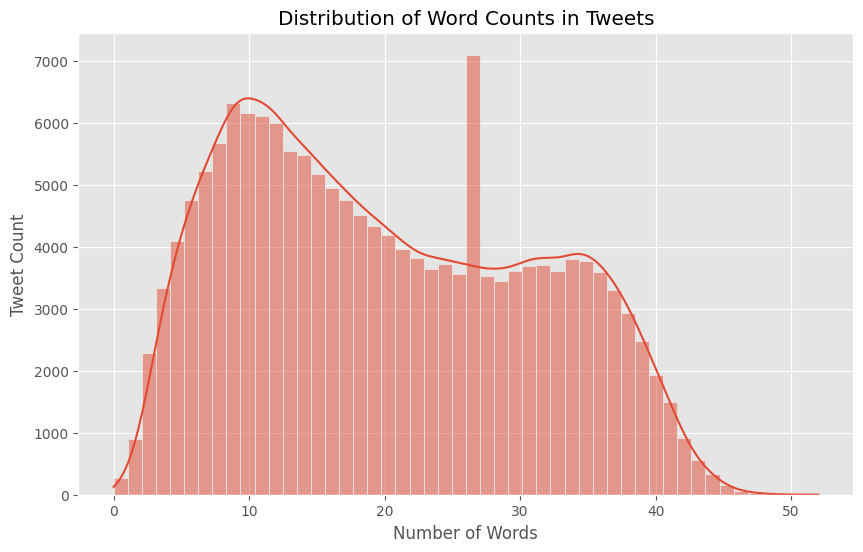

In [45]:
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts in Tweets")
plt.xlabel("Number of Words")
plt.ylabel("Tweet Count")
plt.show()


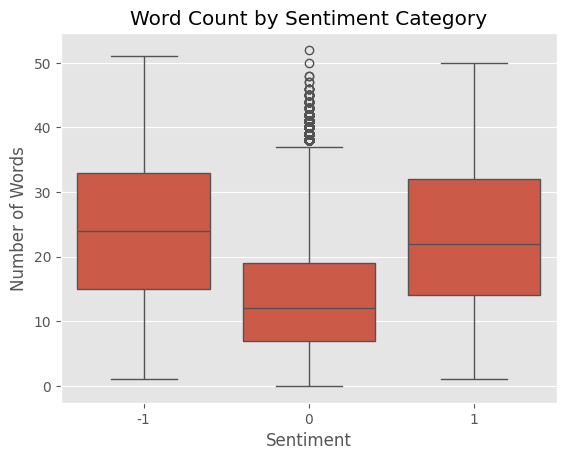

In [46]:
sns.boxplot(x='category', y='word_count', data=df)
plt.title("Word Count by Sentiment Category")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()


In [47]:

cat_0 = df[df['category'] == 0]

Q1 = cat_0['word_count'].quantile(0.25)
Q3 = cat_0['word_count'].quantile(0.75)
IQR = Q3 - Q1


outliers = cat_0[(cat_0['word_count'] < Q1 - 1.5 * IQR) | (cat_0['word_count'] > Q3 + 1.5 * IQR)]

print(f"Number of outliers in category 0: {len(outliers)}")
display(outliers.head())


Number of outliers in category 0: 1063


,clean_text,category,word_count
59,all are with you sir namo again jai hind jai m...,0,39
375,lost hopes job pak tvanchor after 23may wen mo...,0,38
632,saale petrol price 2013 was today even after y...,0,38
868,liberals show all their talent where they know...,0,39
1622,priyanka you stood with pakistan during the su...,0,40


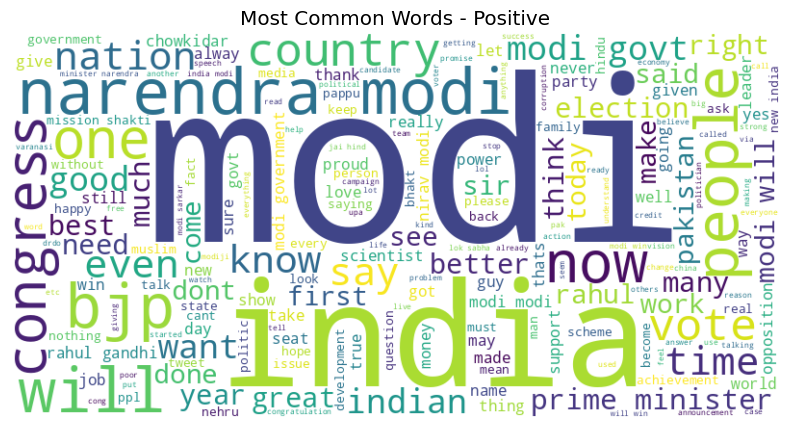

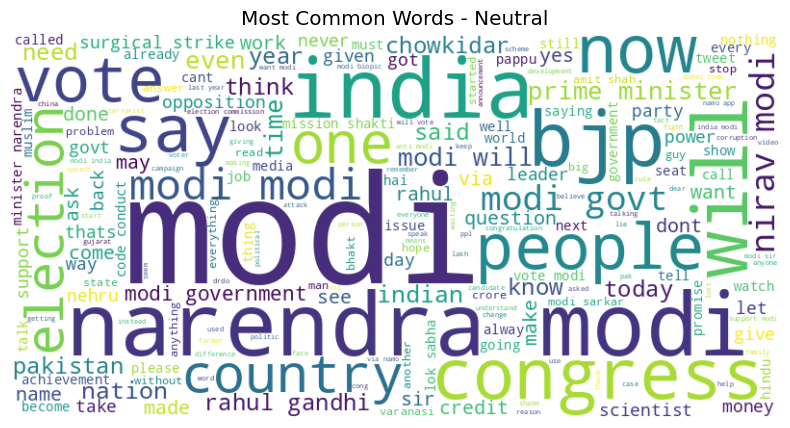

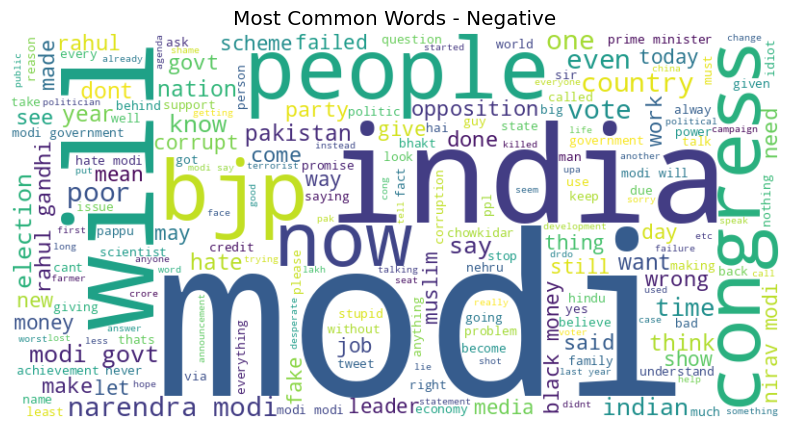

In [48]:
from wordcloud import WordCloud

def generate_wordcloud(category_value, label):
    text = " ".join(df[df['category']==category_value]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Common Words - {label}")
    plt.show()

generate_wordcloud(1, "Positive")
generate_wordcloud(0, "Neutral")
generate_wordcloud(-1, "Negative")


In [49]:
df.groupby('category')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
-1,35509.0,23.880622,10.307720,1.0,15.0,24.0,33.0,51.0
0,55211.0,14.271105,9.075172,0.0,7.0,12.0,19.0,52.0
1,72249.0,22.652673,10.598821,1.0,14.0,22.0,32.0,50.0


In [50]:
df[df['word_count'] <= 1].head(10)

,clean_text,category,word_count
192,song,0,1
1241,joke,0,1
1279,otherwise,0,1
2414,insanity,0,1
2645,bjp,0,1
2686,source,0,1
2807,thanks,1,1
3684,10800rsonly,0,1
4653,gawd,0,1
5395,lols,0,1


In [51]:
df[df['clean_text'].str.strip().isin(['', 'rt'])].head(10)

,clean_text,category,word_count
77224,,0,0


In [52]:
df[df['clean_text'].str.contains(r'^(@\w+\s?)+$', na=False)].head(10)


/tmp/ipython-input-52-1016379830.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[df['clean_text'].str.contains(r'^(@\w+\s?)+$', na=False)].head(10)


,clean_text,category,word_count


In [53]:

df = df[df['word_count'] > 1]
df = df[~df['clean_text'].str.strip().isin(['', 'rt'])]


In [54]:
# How many Deleted 273 noisy tweets
initial_count = 162969
final_count = df.shape[0]
print(f"Deleted {initial_count - final_count} noisy tweets")


Deleted 273 noisy tweets


# Data preprocessing

In [55]:
df['clean_text'] = df['clean_text'].str.lower() #change to lower case

In [56]:
df['clean_text'] = df['clean_text'].str.translate(str.maketrans('', '', string.punctuation)) #Remove punctuation

In [57]:
df['clean_text'] = df['clean_text'].str.replace(r'\d+', '', regex=True)# removw words

In [58]:
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))#remove stopwords

In [59]:
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])) # To return the words to their origin

Train Test

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['category'], test_size=0.2, random_state=42, stratify=df['category']
)

# TF-IDF Vectorization
It is a method that converts words into numbers, so that the model can understand them.

In [61]:
cv = CountVectorizer()
cv.fit(df['clean_text'])


print("The number of unique words:", len(cv.get_feature_names_out()))


The number of unique words: 96833


In [62]:
X = df['clean_text']       #Tweets
y = df['category']         #  (-1, 0, 1)

In [63]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X) #convert to numbers

In [64]:
X_tfidf.shape

(162696, 5000)

In [65]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# Model Training and Evaluation


Logistic Regression

In [66]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [67]:
y_pred = lr_model.predict(X_test_tfidf)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 5376   790   934]
 [  194 10495   311]
 [  599  1017 12824]]
              precision    recall  f1-score   support

          -1       0.87      0.76      0.81      7100
           0       0.85      0.95      0.90     11000
           1       0.91      0.89      0.90     14440

    accuracy                           0.88     32540
   macro avg       0.88      0.87      0.87     32540
weighted avg       0.88      0.88      0.88     32540



In [68]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Random Forest

In [69]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train_tfidf, X_test_tfidf, y_train, y_test)


[[ 4196   907  1997]
 [  105 10011   884]
 [  425  1079 12936]]
              precision    recall  f1-score   support

          -1       0.89      0.59      0.71      7100
           0       0.83      0.91      0.87     11000
           1       0.82      0.90      0.86     14440

    accuracy                           0.83     32540
   macro avg       0.85      0.80      0.81     32540
weighted avg       0.84      0.83      0.83     32540



Support Vector Machine

In [70]:
svm_model = LinearSVC()
evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

[[ 5680   574   846]
 [  238 10465   297]
 [  644   824 12972]]
              precision    recall  f1-score   support

          -1       0.87      0.80      0.83      7100
           0       0.88      0.95      0.92     11000
           1       0.92      0.90      0.91     14440

    accuracy                           0.89     32540
   macro avg       0.89      0.88      0.89     32540
weighted avg       0.89      0.89      0.89     32540



In [71]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test)


[[  938   294  5868]
 [   38  3790  7172]
 [   36   269 14135]]
              precision    recall  f1-score   support

          -1       0.93      0.13      0.23      7100
           0       0.87      0.34      0.49     11000
           1       0.52      0.98      0.68     14440

    accuracy                           0.58     32540
   macro avg       0.77      0.49      0.47     32540
weighted avg       0.73      0.58      0.52     32540



In [72]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


[[ 5376   790   934]
 [  194 10495   311]
 [  599  1017 12824]]
              precision    recall  f1-score   support

          -1       0.87      0.76      0.81      7100
           0       0.85      0.95      0.90     11000
           1       0.91      0.89      0.90     14440

    accuracy                           0.88     32540
   macro avg       0.88      0.87      0.87     32540
weighted avg       0.88      0.88      0.88     32540

0.8818377381684082


# Model Saving

In [76]:
import joblib

joblib.dump(svm_model, "best_sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']